In [1]:
!pip install xgboost

In [2]:
!pip install shap

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import shap
import warnings
warnings.filterwarnings("ignore")

In [4]:
crx_data_path = r"C:\Users\aniru\OneDrive\Desktop\ML tutorial\Credit adjuster\crx.data"
crx_names_path = r"C:\Users\aniru\OneDrive\Desktop\ML tutorial\Credit adjuster\crx.names"
index_path = r"C:\Users\aniru\OneDrive\Desktop\ML tutorial\Credit adjuster\Index"
credit_lisp_path = r"C:\Users\aniru\OneDrive\Desktop\ML tutorial\Credit adjuster\credit.lisp"
credit_names_path = r"C:\Users\aniru\OneDrive\Desktop\ML tutorial\Credit adjuster\credit.names"

In [5]:
column_names = [
    'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8',
    'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'Class'
]
df_credit = pd.read_csv(crx_data_path, names=column_names, na_values='?')

In [6]:
with open(crx_names_path, 'r', encoding='latin-1') as f:
    crx_names = f.read()
with open(index_path, 'r', encoding='latin-1') as f:
    index_file = f.read()
with open(credit_lisp_path, 'r', encoding='latin-1') as f:
    credit_lisp = f.read()
with open(credit_names_path, 'r', encoding='latin-1') as f:
    credit_names = f.read()

In [7]:
print("Files loaded successfully.")
print("DataFrame shape:", df_credit.shape)
print("crx.names preview:\n", crx_names[:300])

Files loaded successfully.
DataFrame shape: (690, 16)
crx.names preview:
 
1. Title: Credit Approval

2. Sources: 
    (confidential)
    Submitted by quinlan@cs.su.oz.au

3.  Past Usage:

    See Quinlan,
    * "Simplifying decision trees", Int J Man-Machine Studies 27,
      Dec 1987, pp. 221-234.
    * "C4.5: Programs for Machine Learning", Morgan Kaufmann, Oct 1992
  


In [8]:
df_clean = df_credit.copy()

In [9]:
categorical_cols = df_clean.select_dtypes(include='object').columns.tolist()
categorical_cols.remove('Class')

In [10]:
numerical_cols = df_clean.columns.difference(categorical_cols + ['Class'])

In [11]:
cat_imputer = SimpleImputer(strategy='most_frequent')
num_imputer = SimpleImputer(strategy='mean')
df_clean[categorical_cols] = cat_imputer.fit_transform(df_clean[categorical_cols])
df_clean[numerical_cols] = num_imputer.fit_transform(df_clean[numerical_cols])

In [12]:
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col])
    label_encoders[col] = le 

In [13]:
df_clean['Class'] = df_clean['Class'].map({'+': 1, '-': 0})

In [14]:
scaler = StandardScaler()
df_clean[numerical_cols] = scaler.fit_transform(df_clean[numerical_cols])

In [15]:
print("Data cleaned and preprocessed.")
print("Feature matrix shape:", df_clean.shape)
df_clean.head()

Data cleaned and preprocessed.
Feature matrix shape: (690, 16)


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,Class
0,1,-0.062321,-0.956613,1,0,12,7,-0.291083,1,1,-0.288101,0,0,0.104544,-0.195413,1
1,0,2.288101,-0.060051,1,0,10,3,0.244190,1,1,0.740830,0,0,-0.819689,-0.087852,1
2,0,-0.596738,-0.856102,1,0,10,3,-0.216324,1,0,-0.493887,0,0,0.557942,-0.037144,1
3,1,-0.315599,-0.647038,1,0,12,7,0.456505,1,1,0.535044,1,0,-0.488360,-0.194837,1
4,1,-0.962303,0.174141,1,0,12,7,-0.153526,1,0,-0.493887,0,2,-0.372104,-0.195413,1


In [16]:
X = df_clean.drop('Class', axis=1)
y = df_clean['Class']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [18]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

In [19]:
for name, model in models.items():
    print(f"\nTraining: {name}")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]
    print("Accuracy:", round(accuracy_score(y_test, preds), 3))
    print("F1 Score:", round(f1_score(y_test, preds), 3))
    print("ROC AUC:", round(roc_auc_score(y_test, probs), 3))
    print("Classification Report:\n", classification_report(y_test, preds))


Training: Logistic Regression
Accuracy: 0.899
F1 Score: 0.889
ROC AUC: 0.958
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.88      0.91        77
           1       0.86      0.92      0.89        61

    accuracy                           0.90       138
   macro avg       0.90      0.90      0.90       138
weighted avg       0.90      0.90      0.90       138


Training: Random Forest
Accuracy: 0.891
F1 Score: 0.872
ROC AUC: 0.955
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91        77
           1       0.91      0.84      0.87        61

    accuracy                           0.89       138
   macro avg       0.89      0.89      0.89       138
weighted avg       0.89      0.89      0.89       138


Training: XGBoost
Accuracy: 0.906
F1 Score: 0.891
ROC AUC: 0.946
Classification Report:
               precision    recall  f1-score   support

   

In [20]:
explainer = shap.Explainer(models["XGBoost"])
shap_values = explainer(X_test)

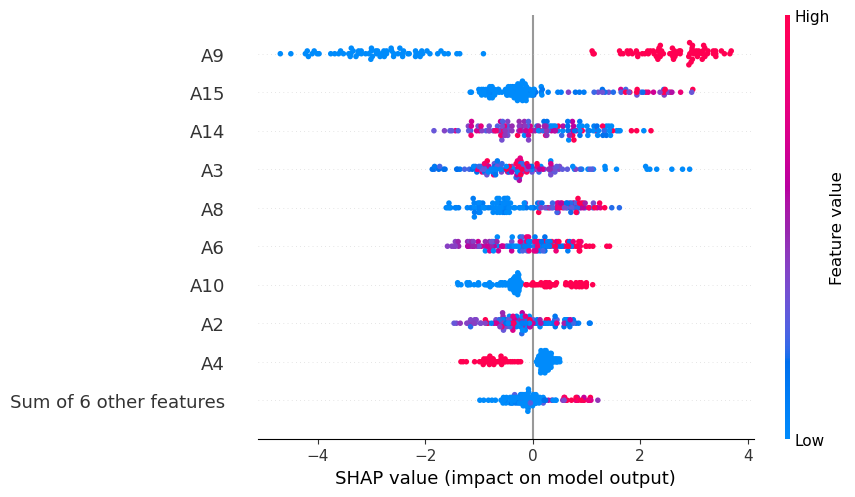

In [21]:
shap.plots.beeswarm(shap_values)

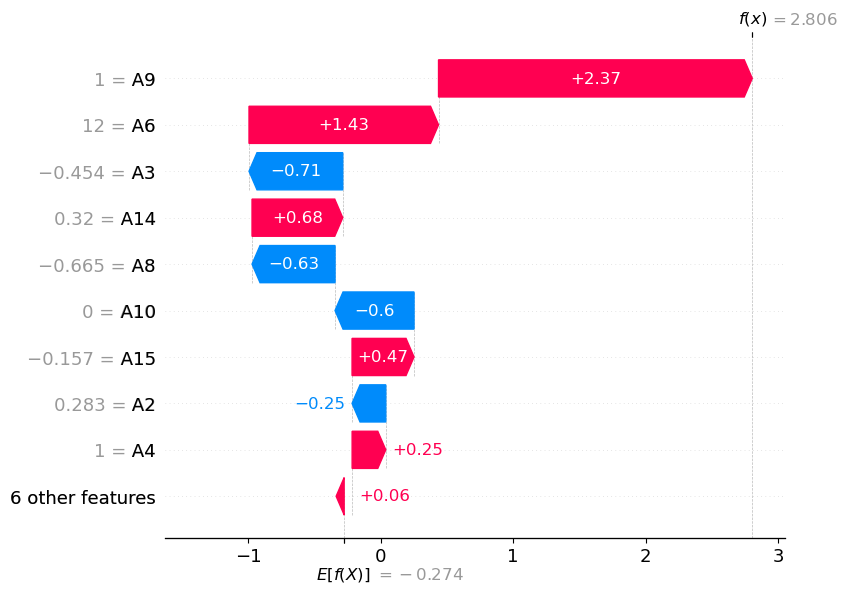

In [22]:
shap.plots.waterfall(shap_values[0])

In [23]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

In [24]:
X = df_clean.drop('Class', axis=1)
y = df_clean['Class']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [26]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

In [27]:
for name, model in models.items():
    print(f"\nTraining: {name}")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]
    print("Accuracy:", round(accuracy_score(y_test, preds), 3))
    print("F1 Score:", round(f1_score(y_test, preds), 3))
    print("ROC AUC:", round(roc_auc_score(y_test, probs), 3))
    print("Classification Report:\n", classification_report(y_test, preds))


Training: Logistic Regression
Accuracy: 0.899
F1 Score: 0.889
ROC AUC: 0.958
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.88      0.91        77
           1       0.86      0.92      0.89        61

    accuracy                           0.90       138
   macro avg       0.90      0.90      0.90       138
weighted avg       0.90      0.90      0.90       138


Training: Random Forest
Accuracy: 0.891
F1 Score: 0.872
ROC AUC: 0.955
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91        77
           1       0.91      0.84      0.87        61

    accuracy                           0.89       138
   macro avg       0.89      0.89      0.89       138
weighted avg       0.89      0.89      0.89       138


Training: XGBoost
Accuracy: 0.906
F1 Score: 0.891
ROC AUC: 0.946
Classification Report:
               precision    recall  f1-score   support

   

In [28]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [29]:
df_cross = df_clean.copy()

In [30]:
df_cross['approval_prob'] = xgb_model.predict_proba(X)[:, 1]

In [31]:
df_cross['decision'] = df_cross['approval_prob'].apply(
    lambda p: 'Approve' if p >= 0.6 else 'Manual Review'
)

In [32]:
def assign_risk(prob):
    if prob >= 0.8:
        return 'Low Risk'
    elif prob >= 0.6:
        return 'Moderate Risk'
    else:
        return 'High Risk'
df_cross['risk_bucket'] = df_cross['approval_prob'].apply(assign_risk)

In [33]:
df_cross['business_rule_flag'] = df_cross['risk_bucket'].apply(lambda x: 1 if x == 'High Risk' else 0)

In [34]:
df_cross['final_decision'] = df_cross.apply(
    lambda row: 'Deny' if row['business_rule_flag'] == 1 else row['decision'],
    axis=1
)

In [35]:
df_cross[['approval_prob', 'decision', 'risk_bucket', 'business_rule_flag', 'final_decision']].head()

,approval_prob,decision,risk_bucket,business_rule_flag,final_decision
0,0.833003,Approve,Low Risk,0,Approve
1,0.999512,Approve,Low Risk,0,Approve
2,0.998048,Approve,Low Risk,0,Approve
3,0.988194,Approve,Low Risk,0,Approve
4,0.982082,Approve,Low Risk,0,Approve


In [36]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X)

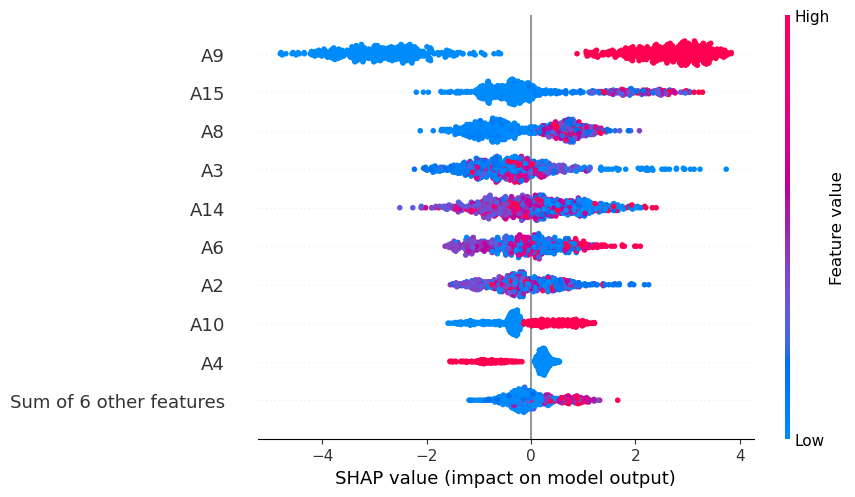

In [37]:
shap.plots.beeswarm(shap_values)

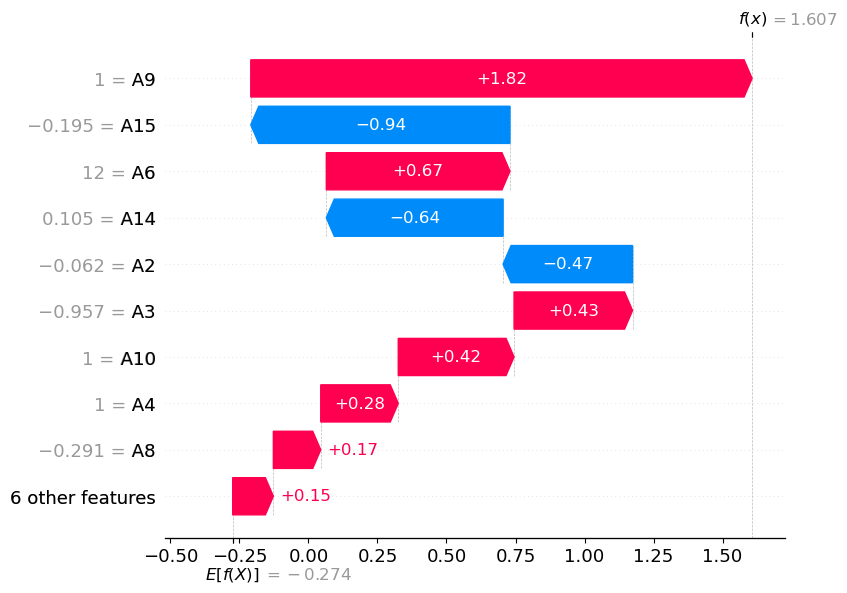

In [38]:
sample_index = 0
shap.plots.waterfall(shap_values[sample_index])

In [39]:
group_approval_rates = df_cross.groupby('A1')['final_decision'].value_counts(normalize=True).unstack()
print(group_approval_rates)

final_decision   Approve      Deny
A1                                
0               0.457143  0.542857
1               0.429167  0.570833


In [40]:
disparity = abs(group_approval_rates.loc[0, 'Approve'] - group_approval_rates.loc[1, 'Approve'])
print(f"Disparate impact (A1): {round(disparity, 3)}")

Disparate impact (A1): 0.028


In [41]:
df_cross['needs_review'] = df_cross.apply(
    lambda row: 1 if (row['approval_prob'] < 0.6 or row['business_rule_flag'] == 1) else 0,
    axis=1
)

In [42]:
df_cross[['approval_prob', 'final_decision', 'risk_bucket', 'business_rule_flag', 'needs_review']].head()

,approval_prob,final_decision,risk_bucket,business_rule_flag,needs_review
0,0.833003,Approve,Low Risk,0,0
1,0.999512,Approve,Low Risk,0,0
2,0.998048,Approve,Low Risk,0,0
3,0.988194,Approve,Low Risk,0,0
4,0.982082,Approve,Low Risk,0,0


In [43]:
df_temporal = df_cross.copy()

In [44]:
df_temporal['application_time'] = pd.date_range(start='2022-01-01', periods=len(df_temporal), freq='H')

In [45]:
df_temporal['application_day'] = df_temporal['application_time'].dt.date
df_temporal['daily_applicant_count'] = df_temporal.groupby('application_day')['application_day'].transform('count')

In [46]:
high_risk_times = df_temporal[df_temporal['risk_bucket'] == 'High Risk']['application_time']
df_temporal['time_since_last_high_risk'] = df_temporal['application_time'].apply(
    lambda t: (t - high_risk_times[high_risk_times < t].max()).total_seconds() / 3600
    if not high_risk_times[high_risk_times < t].empty else np.nan
)

In [47]:
df_temporal['rolling_approval_24h'] = df_temporal['Class'].rolling(window=24, min_periods=1).mean()

In [48]:
df_temporal[['application_time', 'daily_applicant_count', 'time_since_last_high_risk', 'rolling_approval_24h']].head()

,application_time,daily_applicant_count,time_since_last_high_risk,rolling_approval_24h
0,2022-01-01 00:00:00,24,NaN,1.0
1,2022-01-01 01:00:00,24,NaN,1.0
2,2022-01-01 02:00:00,24,NaN,1.0
3,2022-01-01 03:00:00,24,NaN,1.0
4,2022-01-01 04:00:00,24,NaN,1.0


In [49]:
df_anomaly = df_temporal.copy()

In [50]:
exclude_cols = ['application_time', 'application_day', 'risk_bucket', 'final_decision']

In [51]:
X_anomaly = df_anomaly.drop(columns=exclude_cols, errors='ignore')
X_anomaly = X_anomaly.select_dtypes(include=[np.number])

In [52]:
X_anomaly_clean = X_anomaly.dropna()

In [53]:
from sklearn.ensemble import IsolationForest

In [54]:
from sklearn.impute import SimpleImputer

In [55]:
imputer = SimpleImputer(strategy='mean') 
X_anomaly_clean = pd.DataFrame(imputer.fit_transform(X_anomaly), columns=X_anomaly.columns)

In [56]:
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df_anomaly.loc[X_anomaly_clean.index, 'anomaly_flag'] = iso_forest.fit_predict(X_anomaly_clean)

In [57]:
df_anomaly['is_anomaly'] = df_anomaly['anomaly_flag'].map({-1: 1, 1: 0})

In [58]:
df_anomaly[['approval_prob', 'risk_bucket', 'is_anomaly']].head()

,approval_prob,risk_bucket,is_anomaly
0,0.833003,Low Risk,0
1,0.999512,Low Risk,0
2,0.998048,Low Risk,0
3,0.988194,Low Risk,0
4,0.982082,Low Risk,0


In [59]:
X_cluster = df_anomaly.select_dtypes(include=[np.number]).drop(columns=['anomaly_flag', 'is_anomaly'], errors='ignore')

In [60]:
X_cluster = X_cluster.fillna(X_cluster.mean())

In [61]:
df_cluster = df_anomaly.copy()

In [62]:
X_cluster = df_cluster.select_dtypes(include=[np.number])

In [63]:
X_cluster = X_cluster.dropna()
df_cluster = df_cluster.loc[X_cluster.index]

In [64]:
from sklearn.cluster import KMeans

In [65]:
kmeans = KMeans(n_clusters=3, random_state=42)
df_cluster['cluster_id'] = kmeans.fit_predict(X_cluster)

In [66]:
cluster_risk_summary = df_cluster.groupby('cluster_id')['risk_bucket'].value_counts(normalize=True).unstack()

In [67]:
print(cluster_risk_summary)
df_cluster[['cluster_id', 'risk_bucket', 'is_anomaly']].head()

risk_bucket  High Risk  Low Risk  Moderate Risk
cluster_id                                     
0             0.831486  0.164080       0.004435
1             0.028571  0.952381       0.019048
2             0.118421  0.881579            NaN


,cluster_id,risk_bucket,is_anomaly
58,0,Low Risk,1
59,0,Low Risk,0
60,0,Low Risk,0
61,0,Low Risk,0
62,1,Low Risk,0


In [68]:
X = df_cluster.select_dtypes(include=[np.number]).drop(columns=['Class'], errors='ignore').dropna()
y = df_cluster.loc[X.index, 'Class']

In [69]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [70]:
xgb_cost_sensitive = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=2.0  # Adjust based on business risk profile
)
xgb_cost_sensitive.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [71]:
y_pred = xgb_cost_sensitive.predict(X_test)
y_prob = xgb_cost_sensitive.predict_proba(X_test)[:, 1]
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("F1 Score:", round(f1_score(y_test, y_pred), 3))
print("ROC AUC:", round(roc_auc_score(y_test, y_prob), 3))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.921
F1 Score: 0.909
ROC AUC: 0.995
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.87      0.93        77
           1       0.83      1.00      0.91        50

    accuracy                           0.92       127
   macro avg       0.92      0.94      0.92       127
weighted avg       0.93      0.92      0.92       127



In [72]:
df_experimental = df_cluster.copy() 

In [73]:
df_experimental['credit_utilization'] = df_experimental['A14'] / (df_experimental['A15'] + 1)

In [74]:
df_experimental['is_new_customer'] = (df_experimental['A11'] == 0).astype(int)

In [75]:
df_experimental['has_missed_payments'] = (df_experimental['A12'] == 1).astype(int)

In [76]:
df_experimental[['A14', 'A15', 'credit_utilization', 'A11', 'is_new_customer', 'A12', 'has_missed_payments']].head()

,A14,A15,credit_utilization,A11,is_new_customer,A12,has_missed_payments
58,3.063254,-0.195413,3.807239,-0.493887,0,1,1
59,-0.604616,-0.195413,-0.751461,1.769760,0,0,0
60,0.092919,-0.195413,0.115486,0.329258,0,1,1
61,0.383558,-0.055199,0.405967,1.358188,0,0,0
62,-0.604616,-0.118584,-0.685959,-0.082314,0,1,1


In [77]:
df_experimental['A12'] = df_experimental['A12'].map({'t': 1, 'f': 0})

In [78]:
df = df_experimental.copy()
X = df.select_dtypes(include=[np.number]).drop(columns=['Class'], errors='ignore').dropna()
y = df.loc[X.index, 'Class']
df = df.loc[X.index]

In [80]:
print(y.value_counts(dropna=False))

Series([], Name: count, dtype: int64)


In [81]:
df['Class'] = df['Class'].map({'+': 1, '-': 0})

In [82]:
df = df[df['Class'].notna()]

In [83]:
assert set(y.unique()).issubset({0, 1}), "Your target is not binary"

In [86]:
print("X shape:", X.shape)
print("df['Class'] shape:", df['Class'].shape)
print("Any NaNs in Class?", df['Class'].isna().sum())
print("Unique Class values:", df['Class'].unique())

X shape: (0, 27)
df['Class'] shape: (0,)
Any NaNs in Class? 0
Unique Class values: []


In [87]:
df['Class'] = df['Class'].map({'+': 1, '-': 0})
df = df[df['Class'].notna()] 

In [88]:
X = df.select_dtypes(include=[np.number]).drop(columns=['Class'], errors='ignore').dropna()
y = df.loc[X.index, 'Class']

In [89]:
print("Target Distribution:")
print(y.value_counts())

Target Distribution:
Series([], Name: count, dtype: int64)


In [91]:
print(df['Class'].value_counts(dropna=False))
print(df['Class'].unique())
print(df['Class'].head())

Series([], Name: count, dtype: int64)
[]
Series([], Name: Class, dtype: int64)


In [92]:
print(df_experimental.columns)

Index(['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11',
       'A12', 'A13', 'A14', 'A15', 'Class', 'approval_prob', 'decision',
       'risk_bucket', 'business_rule_flag', 'final_decision', 'needs_review',
       'application_time', 'application_day', 'daily_applicant_count',
       'time_since_last_high_risk', 'rolling_approval_24h', 'anomaly_flag',
       'is_anomaly', 'cluster_id', 'credit_utilization', 'is_new_customer',
       'has_missed_payments'],
      dtype='object')


In [93]:
print(df_experimental['Class'].value_counts(dropna=False))
print(df_experimental['Class'].unique())
print(df_experimental['Class'].dtype)

Class
0    383
1    249
Name: count, dtype: int64
[1 0]
int64


In [95]:
print("X shape:", X.shape)
print("Any NaNs in X?", X.isna().sum().sum())
print("X summary stats:\n", X.describe())

X shape: (0, 27)
Any NaNs in X? 0
X summary stats:
         A1   A2   A3   A4   A5   A6   A7   A8   A9  A10  ...  needs_review  \
count  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...           0.0   
mean   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...           NaN   
std    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...           NaN   
min    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...           NaN   
25%    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...           NaN   
50%    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...           NaN   
75%    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...           NaN   
max    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...           NaN   

       daily_applicant_count  time_since_last_high_risk  rolling_approval_24h  \
count                    0.0                        0.0                   0.0   
mean                     NaN                        NaN                   NaN   
st

In [96]:
X = df_experimental.select_dtypes(include=[np.number]).drop(columns=['Class'], errors='ignore')
X = X.fillna(X.mean())

In [97]:
y = df_experimental['Class'].astype(int)

In [98]:
print(X.shape)
print(y.value_counts())

(632, 27)
Class
0    383
1    249
Name: count, dtype: int64


In [99]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [100]:
df['approval_prob'] = model.predict_proba(X)[:, 1]
df['prediction'] = model.predict(X)
df['final_decision'] = df['approval_prob'].apply(lambda p: 'Approve' if p >= 0.6 else 'Manual Review')
df['bias_flag'] = (df['A1'] == 0).astype(int)

In [101]:
explainer = shap.TreeExplainer(model)
shap_vals = explainer.shap_values(X)

In [102]:
top_shap_features = []
for row_vals in shap_vals:
    top_idx = np.argsort(np.abs(row_vals))[::-1][:3]
    top_feats = [X.columns[i] for i in top_idx]
    top_shap_features.append(', '.join(top_feats))
df['top_3_shap_features'] = top_shap_features

In [103]:
audit_trail = df[[
    'prediction', 'approval_prob', 'final_decision',
    'risk_bucket', 'bias_flag', 'top_3_shap_features'
]]

In [105]:
audit_trail.head()

,prediction,approval_prob,final_decision,risk_bucket,bias_flag,top_3_shap_features
0,1,0.988367,Approve,NaN,0,"approval_prob, rolling_approval_24h, time_sinc..."
1,1,0.998461,Approve,NaN,0,"approval_prob, rolling_approval_24h, time_sinc..."
2,1,0.997990,Approve,NaN,0,"approval_prob, rolling_approval_24h, time_sinc..."
3,1,0.999494,Approve,NaN,0,"approval_prob, rolling_approval_24h, time_sinc..."
4,1,0.994939,Approve,NaN,0,"approval_prob, rolling_approval_24h, time_sinc..."
